In [ ]:
import pandas as pd
import numpy as np

import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
%matplotlib inline


from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score

from tensorflow.keras.layers import *
from tensorflow.keras.models import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.callbacks import *

In [2]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
submission = pd.read_csv('sample_submission.csv')

target 별 특징을 생각해보던 중 Image 변환을 시도해 보았습니다. groupby 후 sum을 하여 8 by 4 이미지로 변환해서 살펴봤습니다.

In [3]:
gr_sum = train.groupby('target').sum().iloc[:, 1 :]
gr_sum

,sensor_1,sensor_2,sensor_3,sensor_4,sensor_5,sensor_6,sensor_7,sensor_8,sensor_9,sensor_10,...,sensor_23,sensor_24,sensor_25,sensor_26,sensor_27,sensor_28,sensor_29,sensor_30,sensor_31,sensor_32
target,,,,,,,,,,,,,,,,,,,,,
0,-242.071608,-525.174637,790.896338,318.339940,-395.003926,8.981053,451.345856,-519.794715,-319.702220,-456.367463,...,12.789078,-32.087505,-903.487899,-238.988803,515.336711,86.456027,-356.229142,-468.122673,-353.618223,-1116.399637
1,-397.664728,-445.573394,-596.986389,-457.274292,-411.481413,-495.964005,124.872262,-337.589194,-456.621243,-269.941762,...,-417.386270,-483.181437,-347.276559,-357.301308,147.713326,-296.095303,-506.843392,-391.673585,88.686945,-348.551367
2,-1391.432869,-487.575813,602.179601,47.168832,477.442263,-191.070855,-924.835541,-803.122829,-704.552192,-643.399372,...,549.351023,-333.036933,-355.122904,-350.968574,-1553.345162,-391.824645,-418.984509,-423.552477,-591.410828,-298.997937
3,-589.107303,-934.286454,-2367.004364,-253.169491,-435.655373,-310.730645,1927.719406,-525.098007,-381.128694,-275.497406,...,-80.662266,16.017126,-560.394083,-428.197422,700.286098,-264.381888,-415.349844,-606.913727,-299.628133,27.678038


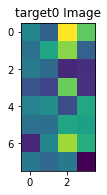

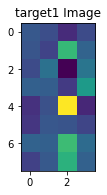

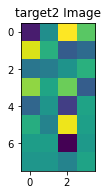

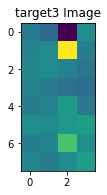

In [4]:
for i in range(1, 5) :
    plt.figure(figsize = (6, 6))
    plt.subplot(2, 2, i)
    plt.imshow(np.array(gr_sum.iloc[i - 1]).reshape(8, 4)) 
    plt.title(f'target{i - 1} Image')

비록 통계량을 통해 봤지만 target별로 어느 정도 다른 형태를 띈다고 볼 수 있을 것 같습니다.

In [5]:
X = train.iloc[:, 1:-1]
target = test.iloc[:, 1:]

sensor1 ~ 32이기 때문에 8 * 4형태로 바꾸어줍니다.

In [8]:
X = np.array(X).reshape(-1, 8, 4, 1)
target = np.array(target).reshape(-1, 8, 4, 1)

MultiClass를 위해 target 값에 One-Hot 인코딩을 취해줍니다.

In [6]:
ohe = OneHotEncoder(sparse = False)

In [7]:
y = ohe.fit_transform(train[['target']])

In [10]:
skf = StratifiedKFold(n_splits = 10, random_state = 42, shuffle = True)

In [122]:
es = EarlyStopping(monitor = 'val_acc', patience = 5, mode = 'max', verbose = 0)

In [139]:
cnn_acc = []
cnn_pred = np.zeros((target.shape[0], 4))
for i, (tr_idx, val_idx) in enumerate(skf.split(X, train.target)) :
    print(f'{i + 1} Fold Training.....')
    tr_x, tr_y = X[tr_idx], y[tr_idx]
    val_x, val_y = X[val_idx], y[val_idx]
    
    ### CNN 모델
    cnn = Sequential()
    cnn.add(Conv2D(8, (2, 2), padding = "same", activation = 'elu', input_shape = (8, 4, 1)))
    cnn.add(BatchNormalization())
    cnn.add(Conv2D(16, (2, 2), padding = "same", activation = 'elu'))
    cnn.add(MaxPooling2D(2, 2))
    cnn.add(Conv2D(32, (3, 3), padding = "same", activation = 'elu'))
    cnn.add(BatchNormalization())
    cnn.add(Conv2D(32, (3, 3), padding = "same", activation = 'elu'))
    cnn.add(BatchNormalization())
    cnn.add(GlobalAveragePooling2D())
    cnn.add(Dense(16, activation = 'relu'))
    cnn.add(Dense(4, activation = 'softmax'))

    ### ModelCheckPoint Fold마다 갱신
    mc = ModelCheckpoint(f'model_{i + 1}.h5', save_best_only = True, monitor = 'val_acc', mode = 'max', verbose = 0)
    
    ### 모델 compile
    cnn.compile(optimizer = RMSprop(learning_rate = 0.04), loss = 'categorical_crossentropy', metrics = ['acc'])

    cnn.fit(tr_x, tr_y, validation_data = (val_x, val_y), epochs = 100, batch_size = 32, callbacks = [es, mc], verbose = 0)

    ### 최고 성능 기록 모델 Load
    best = load_model(f'model_{i + 1}.h5')
    ### validation predict
    val_pred = best.predict(val_x)
    ### 확률값 중 최대값을 클래스로 매칭
    val_cls = np.argmax(val_pred, axis = 1)
    ### Fold별 정확도 산출
    fold_cnn_acc = accuracy_score(np.argmax(val_y, axis = 1), val_cls)
    cnn_acc.append(fold_cnn_acc)
    print(f'{i + 1} Fold ACC of CNN = {fold_cnn_acc}\n')

    ### Fold별 test 데이터에 대한 예측값 생성 및 앙상블
    fold_pred = best.predict(target) / skf.n_splits
    cnn_pred += fold_pred

1 Fold Training.....
1 Fold ACC of CNN = 0.8034188034188035
2 Fold Training.....
2 Fold ACC of CNN = 0.8205128205128205
3 Fold Training.....
3 Fold ACC of CNN = 0.8376068376068376
4 Fold Training.....
4 Fold ACC of CNN = 0.8760683760683761
5 Fold Training.....
5 Fold ACC of CNN = 0.8076923076923077
6 Fold Training.....
6 Fold ACC of CNN = 0.8197424892703863
7 Fold Training.....
7 Fold ACC of CNN = 0.8068669527896996
8 Fold Training.....
8 Fold ACC of CNN = 0.8197424892703863
9 Fold Training.....
9 Fold ACC of CNN = 0.8497854077253219
10 Fold Training.....
10 Fold ACC of CNN = 0.8412017167381974


In [140]:
np.mean(cnn_acc)

0.8282638201093135

In [144]:
submission['target'] = np.argmax(cnn_pred, axis = 1)

In [145]:
submission.to_csv('1st.csv', index = False)

In [146]:
submission.target.value_counts()

1    2471
2    2367
0    2272
3    2233
Name: target, dtype: int64